In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import glob as glob
from matplotlib import cm
from matplotlib import colors as c
from gqp_mc import data as Data 
from gqp_mc import fitters as Fitters

Adaptive Evaluation Step = 1000


In [3]:
specs,meta = Data.Spectra(sim='lgal',noise = 'none', lib = 'bc03', sample = 'mini_mocha')
photo, _ = Data.Photometry(sim='lgal', noise= 'none', lib='bc03', sample='mini_mocha') 
input_mass = meta['logM_total'][:10]

In [4]:
class convergence_plotter():
    def __init__(self,walkers,num_run,data_dir):
        self.num_walkers = walkers
        self.num_run = num_run
        self.data_dir = data_dir
        self.files = []
        
    def post(self):
        data = [x for x in self.files]
        
        return data
        
    def opener(self):
        f = [x for x in glob.glob(f'{self.data_dir}/*.hdf5')]  
        f.sort()
        print(f)
        files = []
        
        for i in f:
            file = h5py.File(i,'r')
            files.append(file)
        
        self.files = files
        return None
    def walker_perc_plot(self,spec_photo,step=1000, flag = ""):
        import seaborn as sns
        data = [x['mcmc_chain'][...][:,0] for x in self.files]
        num_gal = len(data)
        
        for sample,idx in zip(data,range(num_gal)):
            plt.figure(figsize=(12,9))
            plt.xlabel('$N_{iteration}$')
            plt.ylabel('Median')
            plt.grid()
            plt.title(f'{spec_photo} galaxy {idx + 1} walker-percentile plot{flag}')
            plt.axhline(input_mass[idx], lw = 1, c = 'r')
            plt.text(1000,input_mass[idx],f'{input_mass[idx]}')
            #plt.xlim(-10000,None)
            
            colors = plt.cm.copper(np.linspace(0,1,self.num_walkers))            
            for i in range(self.num_walkers):
                y,up_perc,lo_perc = [], [], []
                length = len(sample)//self.num_walkers
                inc = length//step
                x_axis = (np.arange(inc)+1)*step
                for n in range(inc):
                    walker_sample = sample[i:step * (1+n):self.num_walkers]
                    up = np.percentile(walker_sample,84.1)
                    lo = np.percentile(walker_sample,15.9)
                    med = np.median(walker_sample)
                    up_perc.append(up-med)
                    lo_perc.append(med-lo)
                    y.append(med)
                    
                yerr = np.vstack((up_perc,lo_perc))
                plt.plot(x_axis,y,label= f'walker {i+1}',lw = 0.5,c = 'grey')#colors[i])
                plt.fill_between(x_axis, np.array(y)-np.array(lo_perc), np.array(y)+np.array(up_perc),color='gray', alpha=0.05)
                
            plt.savefig(f'Walker-Percentile plot galaxy {idx+1}{flag}.pdf', format = 'pdf')
            plt.show()
    
    def avg_perc_plot(self,spec_photo,step=1000):
        data = [x['mcmc_chain'][...][:,0] for x in self.files]
        num_gal = len(data)
        
        for sample,idx in zip(data,range(num_gal)):
            y,up_perc,lo_perc = [], [], []
            length = len(sample)
            inc = length//step
            x_axis = (np.arange(inc)+1)*step
            for n in range(inc):
                up = np.percentile(sample[:step*(1+n)],84.1)
                lo = np.percentile(sample[:step*(1+n)],15.9)
                med = np.median(sample[:step*(1+n)])
                up_perc.append(up-med)
                lo_perc.append(med-lo)
                y.append(med)
            
            yerr = np.vstack((up_perc,lo_perc))    
            plt.figure(figsize=(12,9))
            plt.xlabel('$N_{iteration}$')
            plt.ylabel('Median')
            plt.grid()
            plt.title(f'{spec_photo} galaxy {idx+1} percentile plot')
            plt.axhline(input_mass[idx], lw = 1, c = 'r')
            plt.text(1000,input_mass[idx],f'{input_mass[idx]}')
            plt.text(length,y[-1],f'{y[-1]}')
            plt.errorbar(x_axis,y,yerr=yerr,fmt = '.k', ecolor = 'gray', elinewidth=1,capsize=1)
            plt.xlim(-10000,None)
            plt.savefig(f'Percentile plot galaxy {idx+1}.pdf', format = 'pdf')
            plt.show()
    def hist_plot(self,spec_photo,step=1000):
        data = [x['mcmc_chain'][...][:,0] for x in self.files]
        num_gal=len(data)
            
        for sample,idx in zip(data,range(num_gal)):
            length = len(sample)
            inc = length//step
            colors = plt.cm.copper_r(np.linspace(0,1,inc))
            plt.figure(figsize=(12,9))
            for n in range(inc):
                hist = plt.hist(sample[:(1+n)*step],bins=50,histtype='step',color=colors[n],density='True',linewidth=1.2)

            plt.xlabel('$log M*$')
            plt.ylabel('Frequency')
            plt.title(f'{spec_photo } galaxy {idx+1} histogram')
            norm = c.Normalize(vmin=1,vmax=length) #Upper and lower boundaries for the color bar
            cbar = plt.colorbar(cm.ScalarMappable(norm = norm, cmap=cm.copper_r))
            plt.show()
                      
        return None
    
    def GRD2(self,sample):
        M = self.num_walkers
        N = len(sample)//M
        r_sample = []
        for idx in range(self.num_walkers):
            r_sample.append(sample[idx::self.num_walkers])
        means = []
        sq_means = []
        
        for m in r_sample:

            means.append(np.mean(m))
            sq_means.append(np.mean(m**2))
            
        tot_mean = np.mean(means)
        B = N*np.sum((means-tot_mean)**2)/(M-1)
        W = np.sum(sq_means-np.square(means))/M
        p_var = W*(N-1)/N+(M+1)*B/(M*N)
        PSRF = p_var/W

        return PSRF
    
        
    def GRD(self,sample):
        M = self.num_walkers
        N = len(sample)//M
        r_sample = np.reshape(sample,(M,N))
        means = [] #For E(X)
        sq_means = [] #For E(X^2)

        for m in r_sample:
            means.append(np.mean(m))
            sq_means.append(np.mean(m**2))

        tot_mean = np.mean(means)
        B = N*np.sum((means-tot_mean)**2)/(M-1)
        W = np.sum(sq_means-np.square(means))/M
        p_var = W*(N-1)/N+(M+1)*B/(M*N)
        PSRF = p_var/W


        return PSRF

    def PSRF_plot(self,spec_photo,step=1000):
        data = [x['mcmc_chain'][...][:,0] for x in self.files]
        num_gal = len(data)

        for sample,idx in zip(data,range(num_gal)):
            PSRFs = []
            length = len(sample)
            inc = length//step
            x_axis = np.arange(inc)*step
            plt.figure(figsize=(12,9))
            for n in range(inc):
                PSRFs.append(self.GRD2(sample[:(1+n)*step]))
            
            plt.plot(x_axis,PSRFs, c = 'k', lw = 2)
            plt.axhline(1.1, c = 'r', ls = '--', lw = 1)
            plt.ylim(0,None)
            plt.xlim(0,None)
            plt.grid()
            plt.xlabel('$N_{iteration}$')
            plt.ylabel('Potential Scale Reduction Factor (PSRF)')
            plt.title(f'{spec_photo} galaxy {idx+1} PSRF plot')
            plt.savefig(f'{spec_photo} galaxy {idx+1} PSRF plot.pdf', format = 'pdf')
            plt.show()
            
Adptv = convergence_plotter(20,10000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/GRD_test')
Adptv.opener()

['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/GRD_test/lgal.specphoto.noise_none.vanilla.0.hdf5', '/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/GRD_test/lgal.specphoto.noise_none.vanilla.1.hdf5', '/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/GRD_test/lgal.specphoto.noise_none.vanilla.2.hdf5', '/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/GRD_test/lgal.specphoto.noise_none.vanilla.3.hdf5', '/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/GRD_test/lgal.specphoto.noise_none.vanilla.4.hdf5', '/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/GRD_test/lgal.specphoto.noise_none.vanilla.5.hdf5', '/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/GRD_test/lgal.specphoto.noise_none.vanilla.6.hdf5', '/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/GRD_test/lgal.specphoto.noise_none.vanilla.7.hdf5', '/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_m

In [139]:
from gqp_mc import fitters as Fitters
import h5py 
import fsps
import numpy as np 
# --- astropy --- 
from astropy import units as U
from astropy.cosmology import Planck13 as cosmo
# --- speclite ---
from speclite import filters as specFilter
# --- gqp_mc --- 
from gqp_mc import util as UT
import sys 
import os 
import h5py 
import numpy as np 
import corner as DFM 
from functools import partial
from multiprocessing.pool import Pool 
# --- gqp_mc ---
from gqp_mc import util as UT 
from gqp_mc import data as Data 
from gqp_mc import fitters as Fitters
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt

In [140]:
ifsps = Fitters.iFSPS(model_name = 'vanilla', prior = None)

In [297]:
chain = Adptv.post()
gal1 = chain[9]

logM1 = gal1['mcmc_chain'][:,0]
logZ1 = gal1['mcmc_chain'][:,1]
tage1 = gal1['mcmc_chain'][:,2]
dst21 = gal1['mcmc_chain'][:,3]
tau_1 = gal1['mcmc_chain'][:,4]
fibr1 = gal1['mcmc_chain'][:,5]
prior = gal1['priors']

def getpos(idx):
    a = logM1
    b = logZ1
    c = tage1
    d = dst21
    e = tau_1
    f = fibr1
    return np.array([a[idx],b[idx],c[idx],d[idx],e[idx],f[idx]])

prior_arr = prior
prior_min, prior_max = prior_arr[:,0], prior_arr[:,1]



In [298]:
# read noiseless Lgal spectra of the spectral_challenge mocks 
specs, meta = Data.Spectra(sim='lgal', noise='none', lib='bc03', sample='mini_mocha') 

# read Lgal photometry of the mini_mocha mocks 
photo, _ = Data.Photometry(sim='lgal', noise='none', lib='bc03', sample='mini_mocha') 

model       = 'vanilla'
w_obs       = specs['wave']
flux_obs    = specs['flux'][9]
ivar_obs = np.ones(len(w_obs)) 
photo_obs   = photo['flux'][9,:5]
photo_ivar_obs = np.ones(photo_obs.shape[0]) 

f_fiber_true = (photo['fiberflux_r_meas'][9]/photo['flux_r_true'][9]) 
f_fiber_min = (photo['fiberflux_r_meas'][9] - 3.*photo['fiberflux_r_ivar'][9]**-0.5)/photo['flux'][9,1]
f_fiber_max = (photo['fiberflux_r_meas'][9] + 3.*photo['fiberflux_r_ivar'][9]**-0.5)/photo['flux'][9,1]
f_fiber_prior = [f_fiber_min, f_fiber_max]
mask = 'emline'
zred = meta['redshift'][9]
wave_obs = w_obs
flux_ivar_obs = ivar_obs

_mask = ifsps._check_mask(mask, wave_obs, flux_ivar_obs, zred) 

# get photometric bands  
bands_list = ifsps._get_bands('desi')
# get filters
filters = specFilter.load_filters(*tuple(bands_list))

In [299]:
def posterior(idx):
    dtt_min = getpos(idx) - prior_min 
    dtt_max = prior_max - getpos(idx)
    if ((np.min(dtt_min) > 0) and (np.min(dtt_max) > 0)):
        lp = 0
    else:
        lp = -np.inf
    if not np.isfinite(lp):
        return -np.inf
    
    else:
        chi_tot = ifsps._Chi2(getpos(idx)[:-1], wave_obs, flux_obs, flux_ivar_obs, zred, mask=_mask, f_fiber=getpos(idx)[-1]) + \
        ifsps._Chi2_photo(getpos(idx)[:-1], photo_obs, photo_ivar_obs, zred, filters=filters, bands=bands_list)
        return lp - 0.5 * chi_tot

In [302]:
chi  = []
for i in np.arange(0,200000,100):
    print(i, end = '\r')
    chi.append(posterior(i))

/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]
/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/speclite/filters.py:1520: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  integrand = integrand[values_slice]


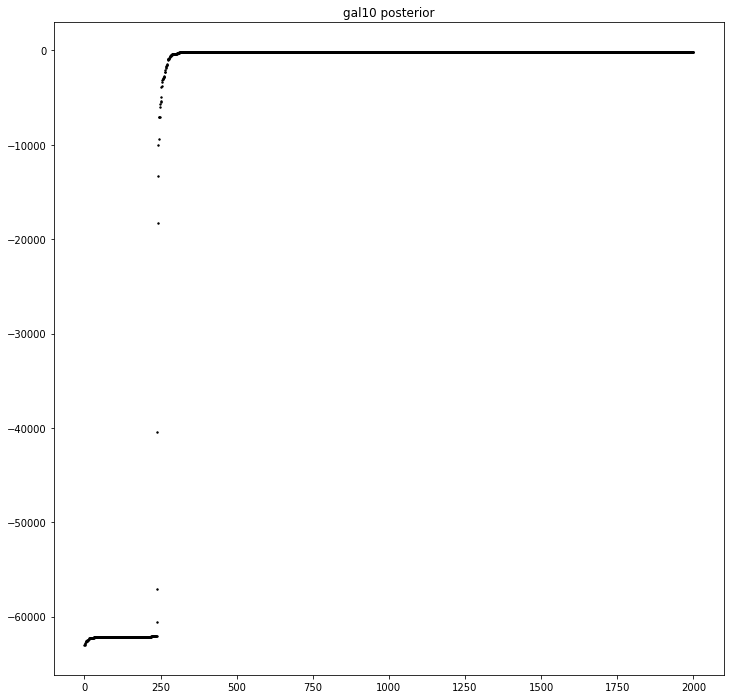

In [303]:
plt.figure(figsize=(12,12))
plt.scatter(np.arange(len(chi[::])),chi[::],s = 2, c = 'k')
plt.title('gal10 posterior')
plt.savefig('gal10_posterior_100step.pdf', format = 'pdf')

### Chain 0

['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/Walker_Test/lgal.specphoto.noise_none.vanilla.0.hdf5', '/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/Walker_Test/lgal.specphoto.noise_none.vanilla.1.hdf5', '/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/Walker_Test/lgal.specphoto.noise_none.vanilla.2.hdf5']


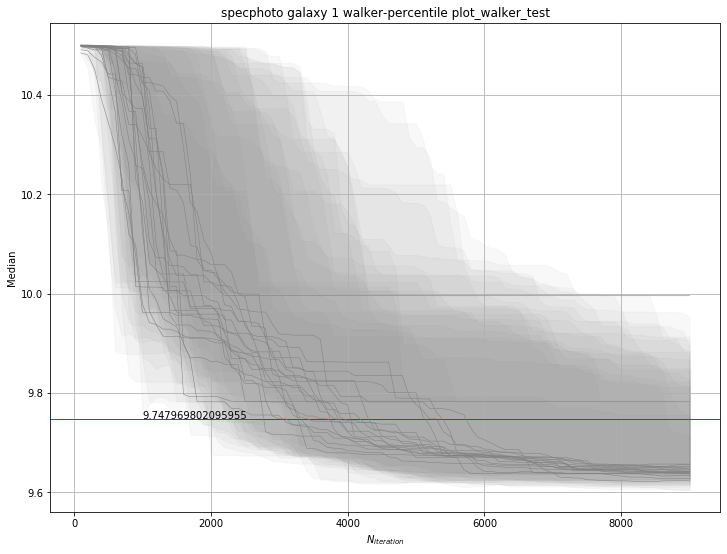

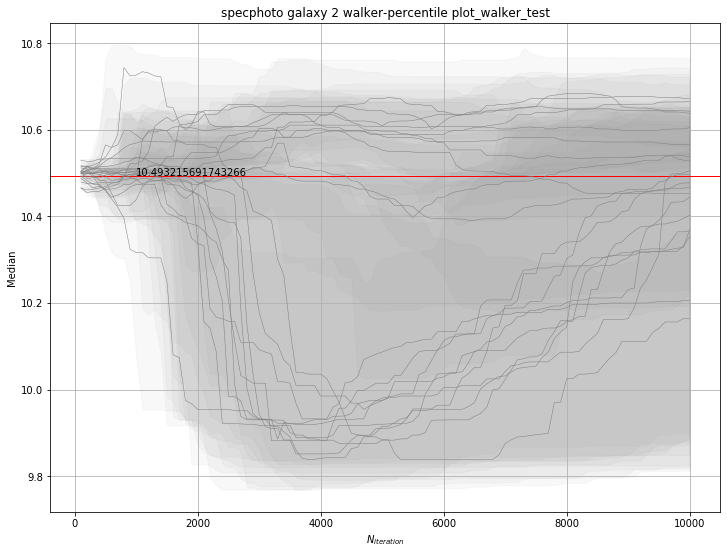

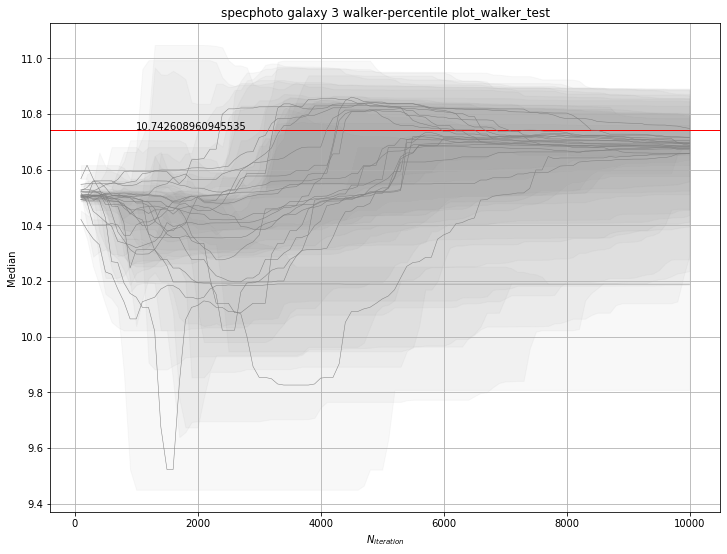

In [225]:
Adptv2 = convergence_plotter(20,10000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/Walker_Test')
Adptv2.opener()
Adptv2.walker_perc_plot('specphoto',step=100,flag="_walker_test")

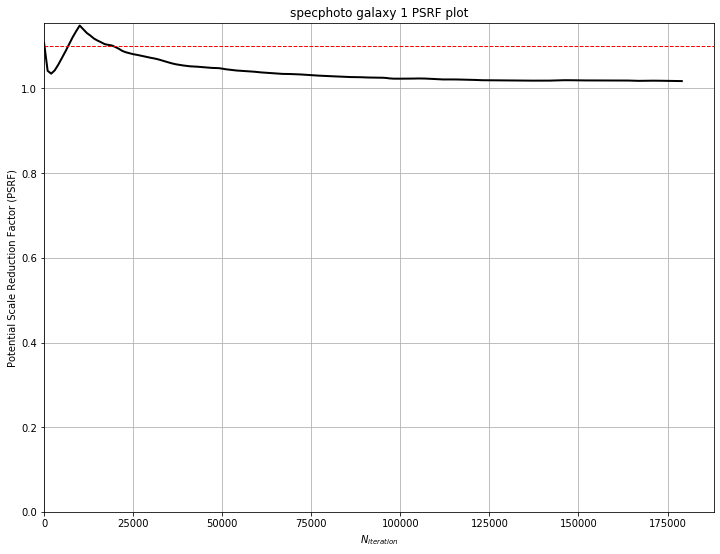

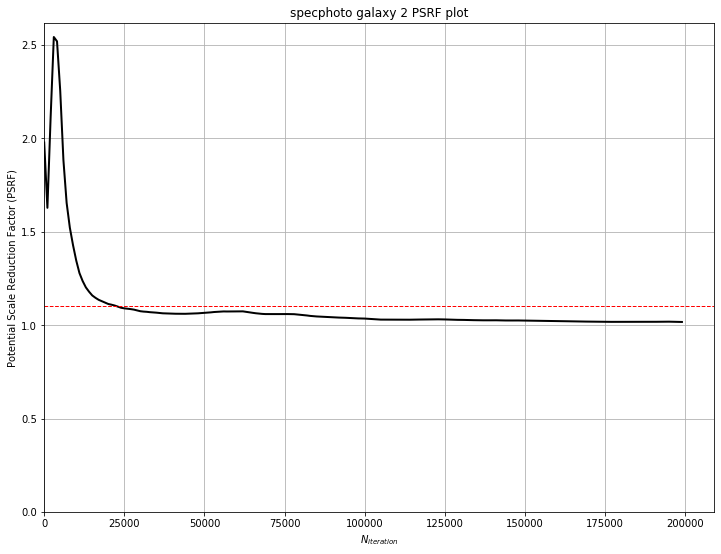

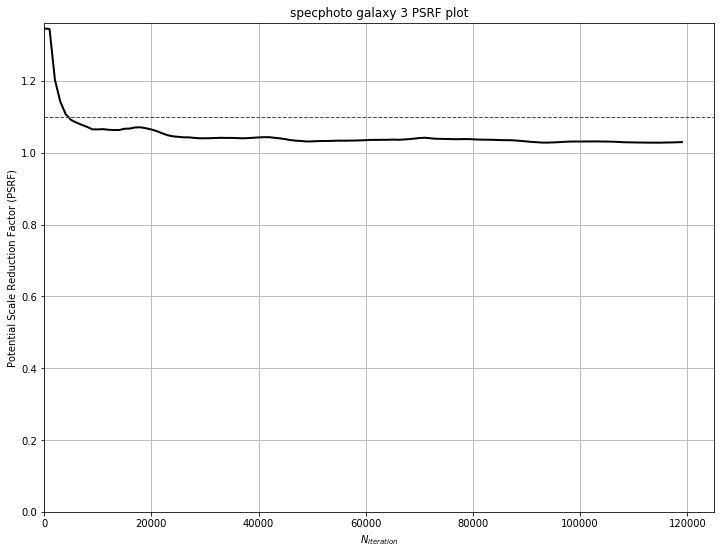

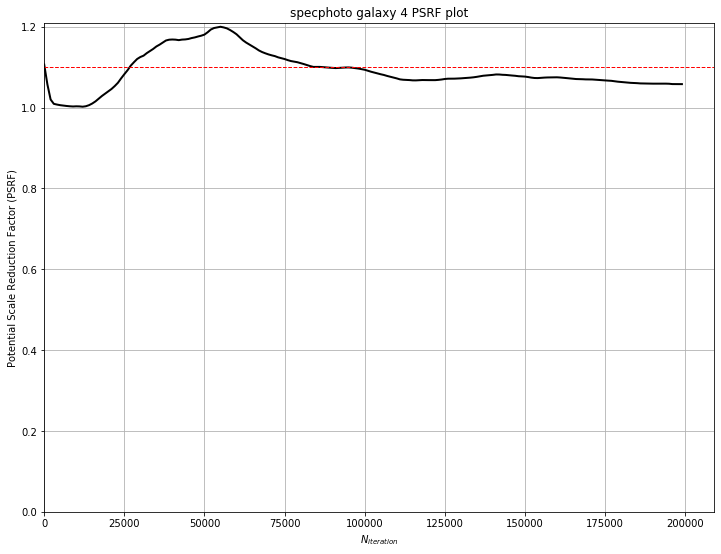

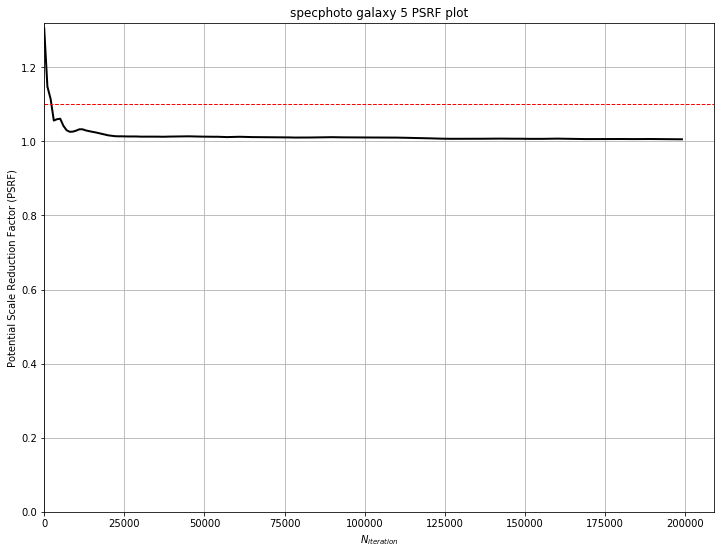

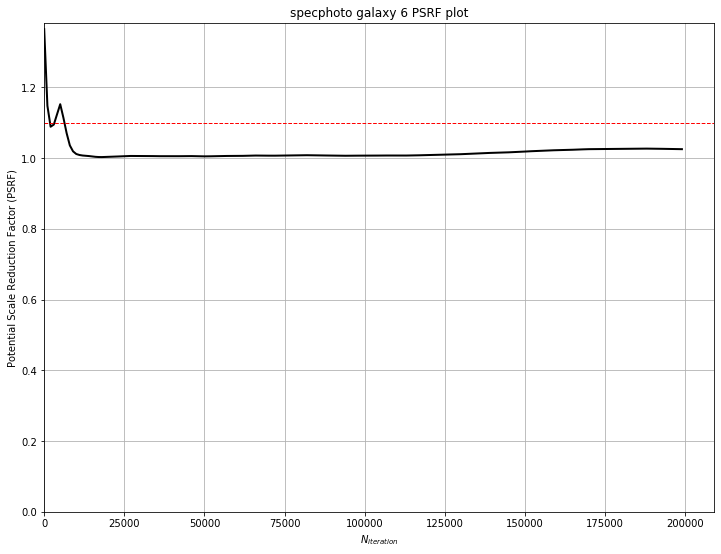

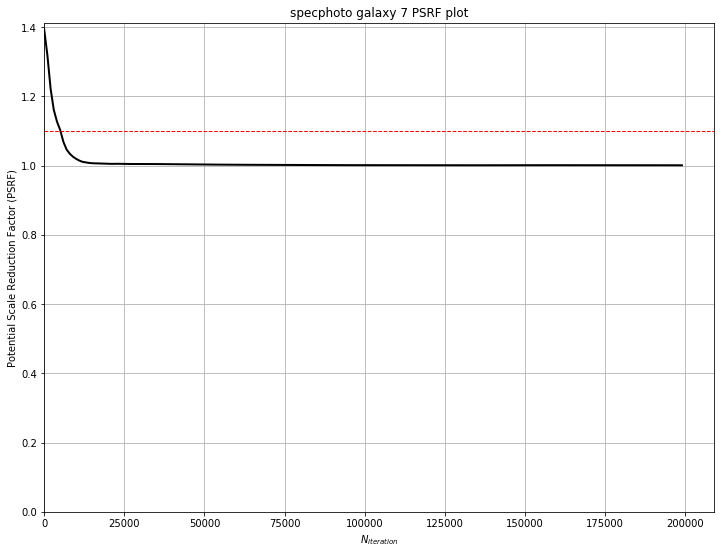

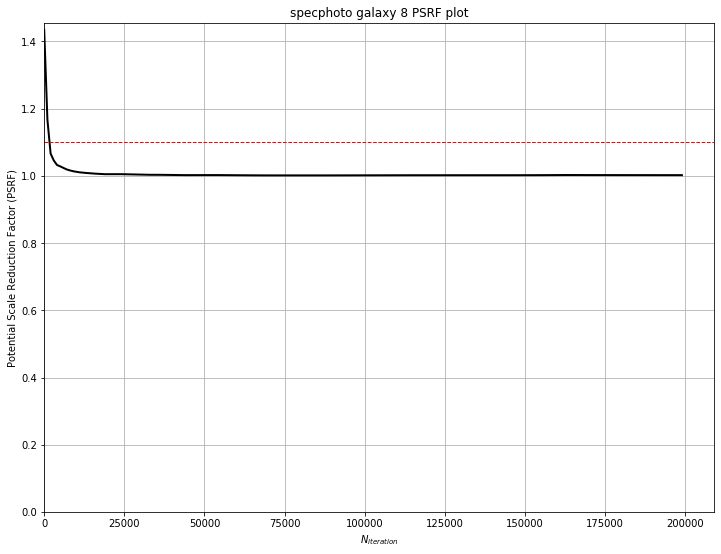

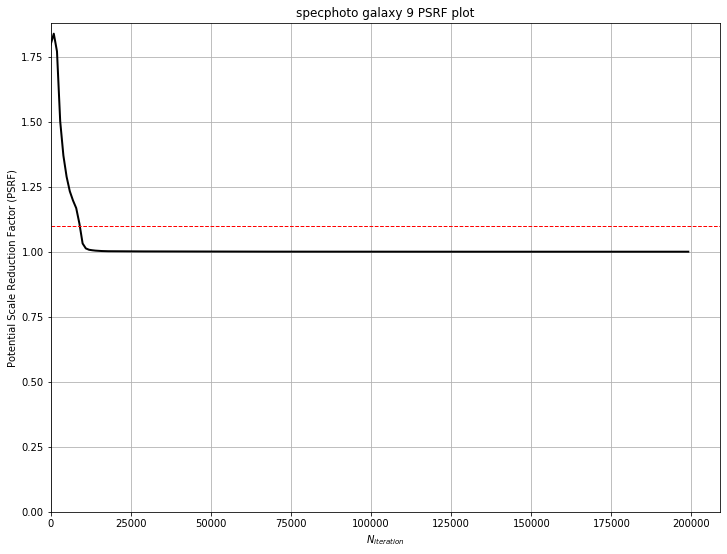

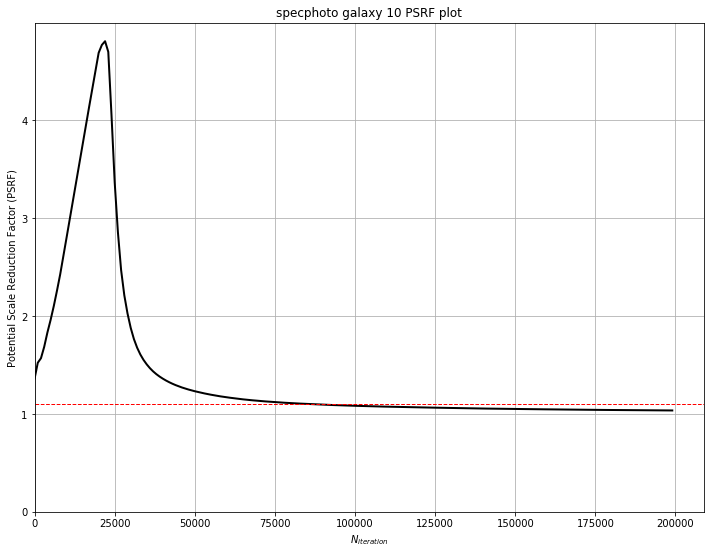

In [5]:
Adptv.PSRF_plot('specphoto')

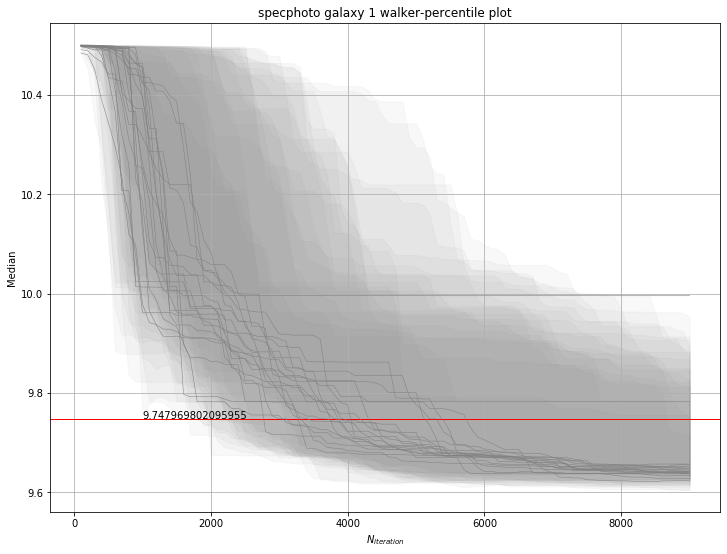

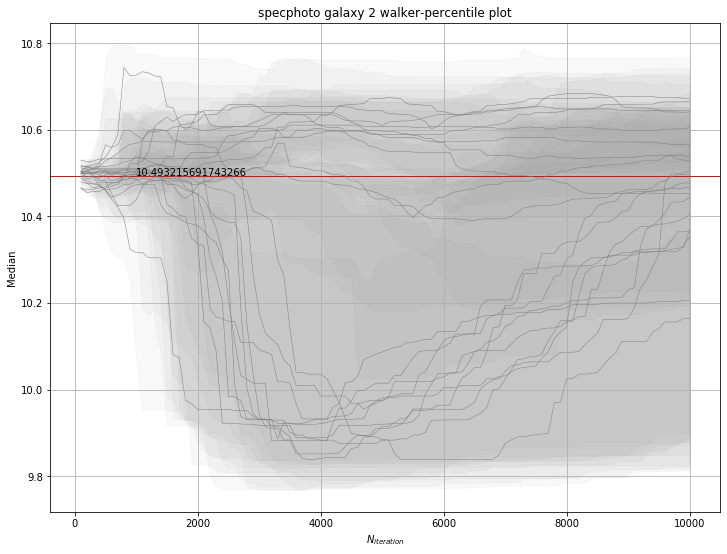

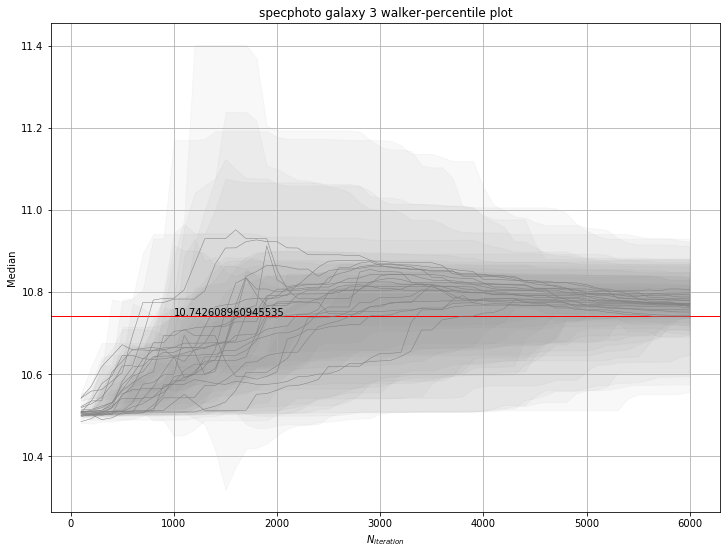

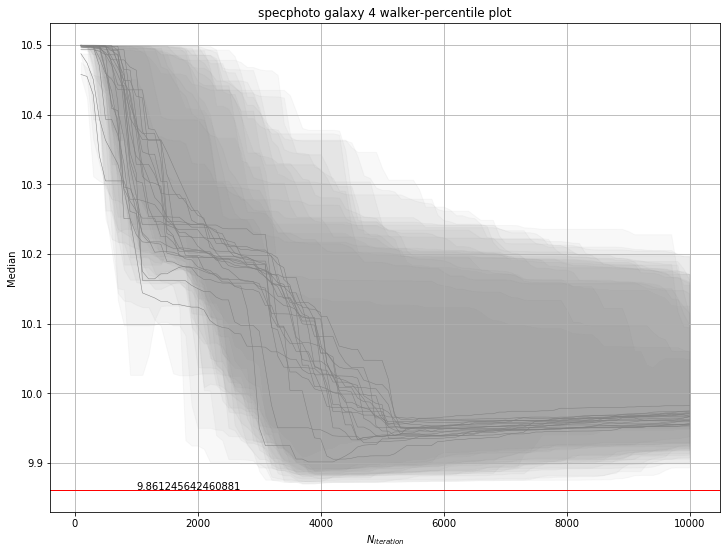

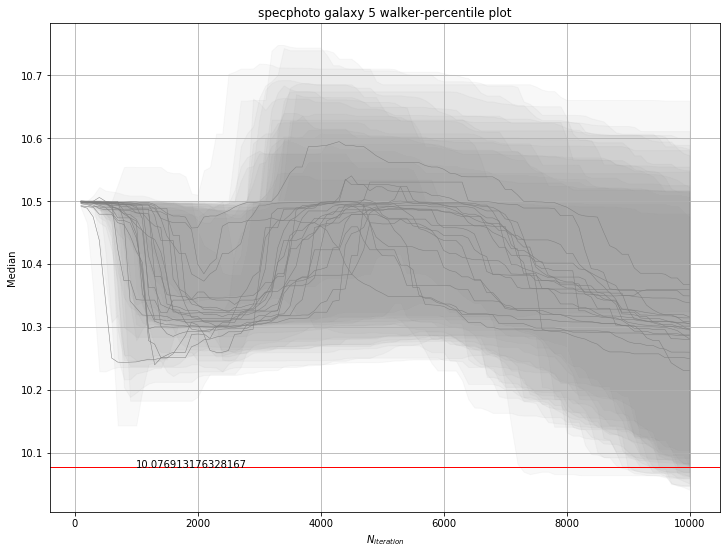

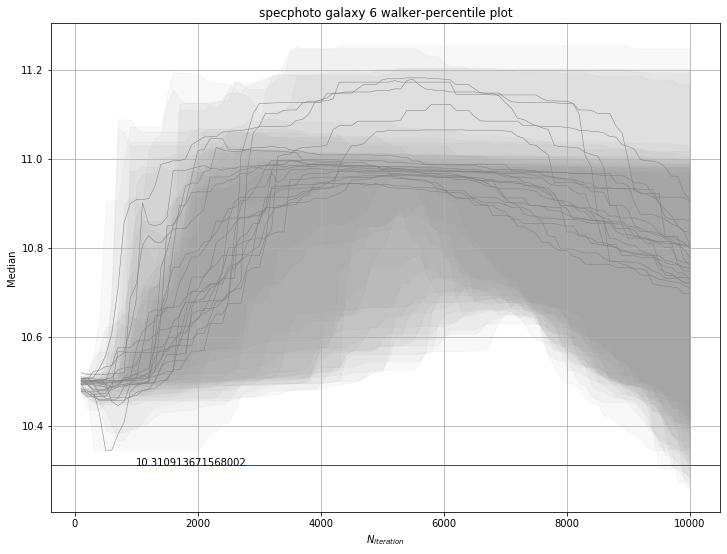

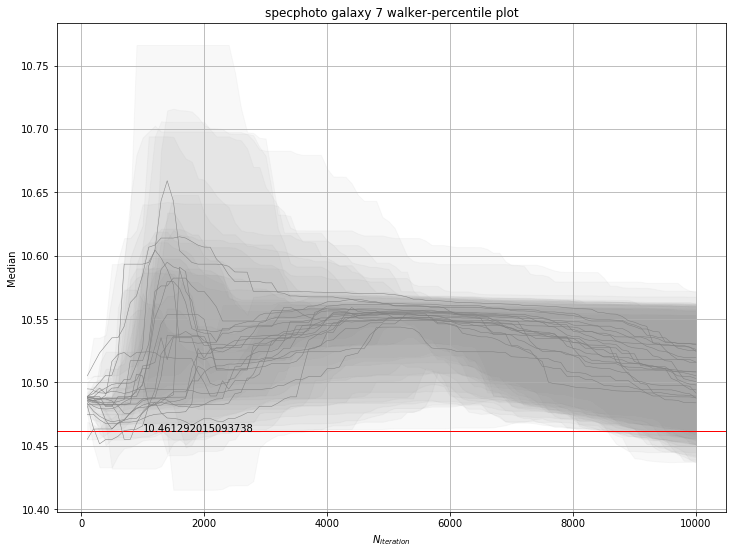

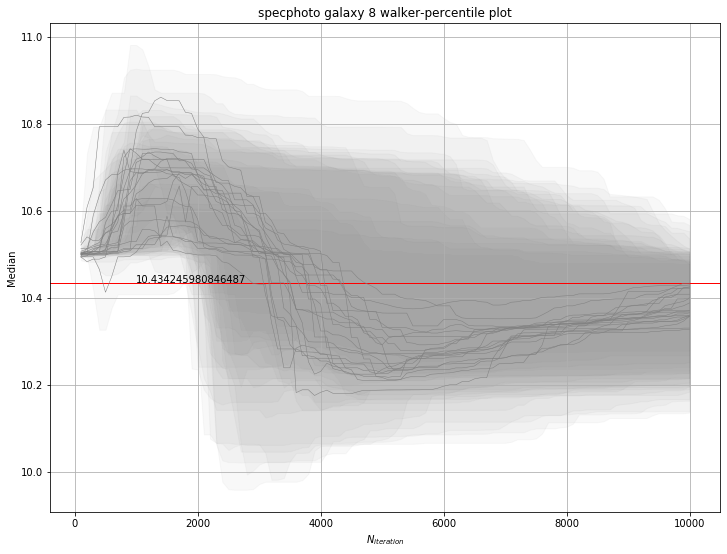

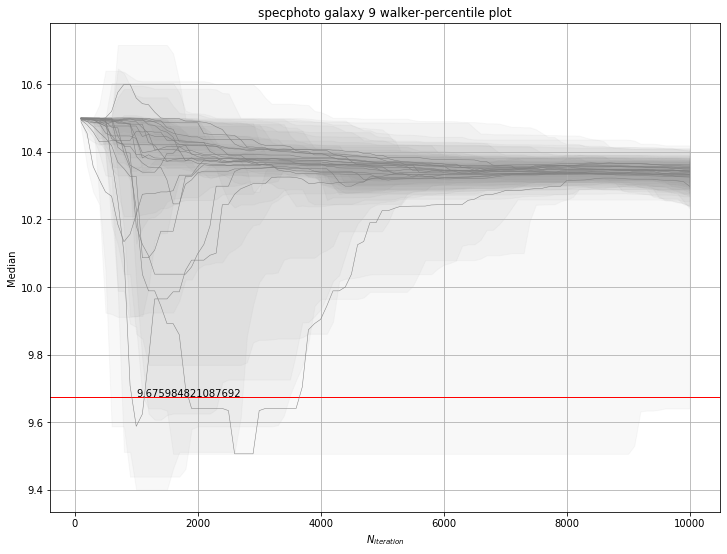

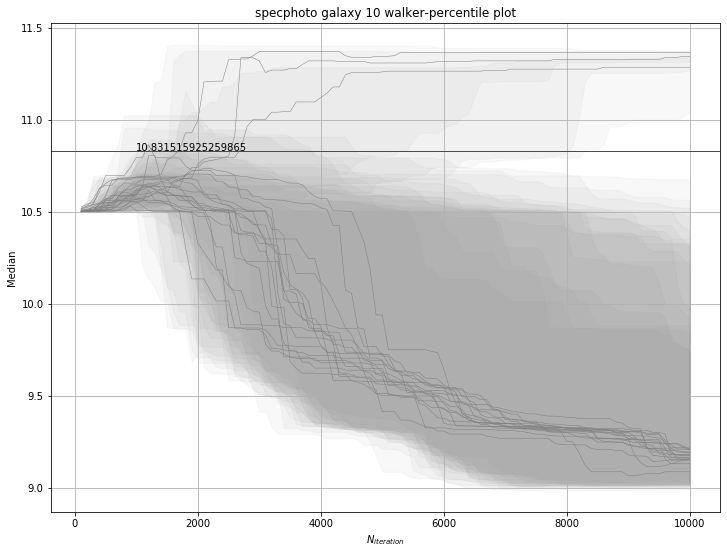

In [6]:
Adptv.walker_perc_plot('specphoto',step = 100)

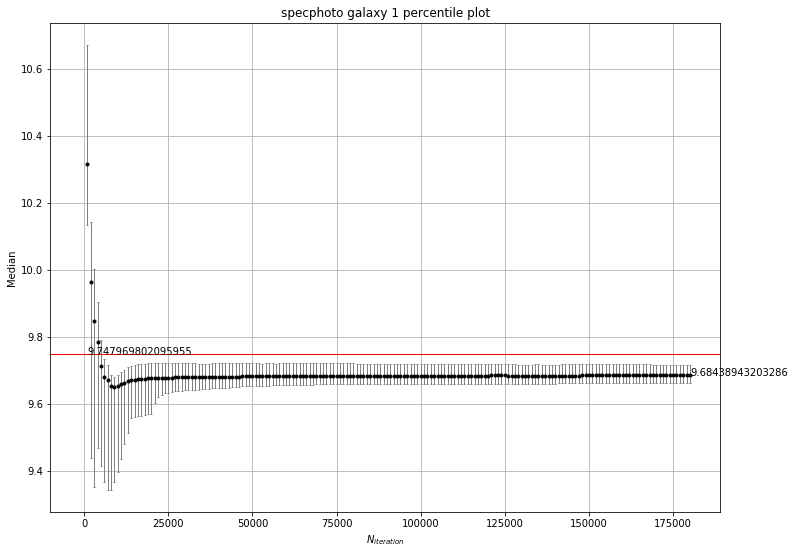

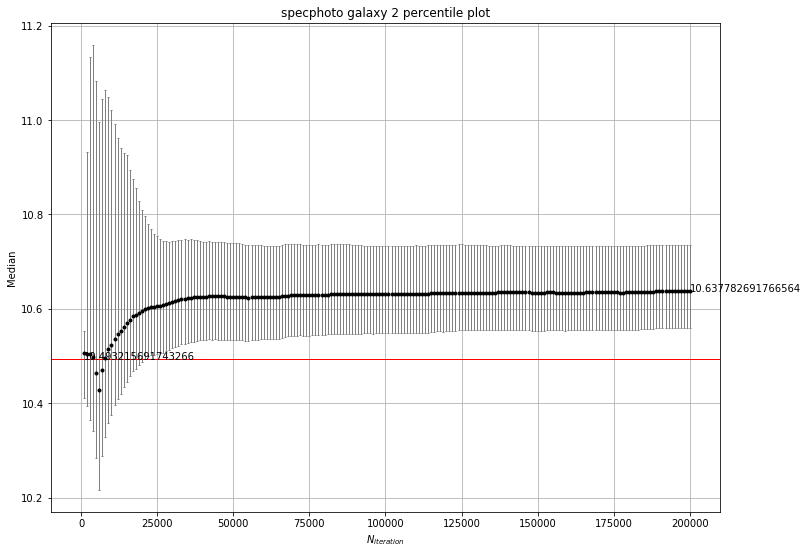

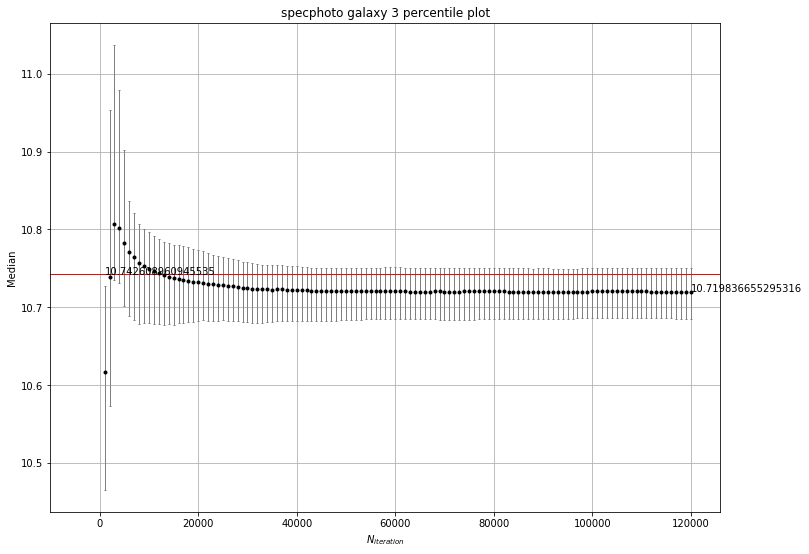

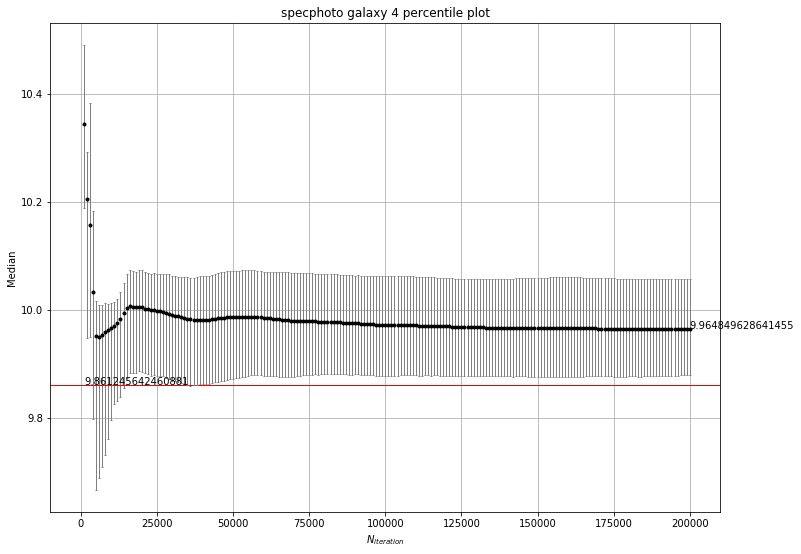

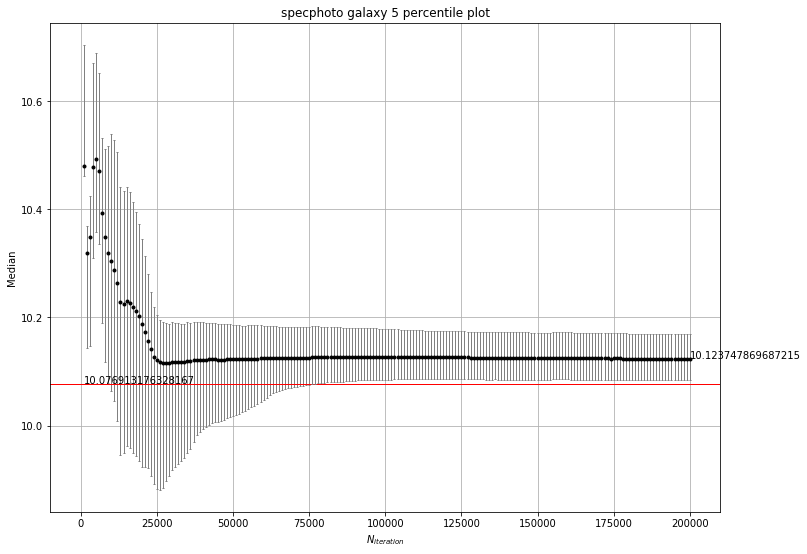

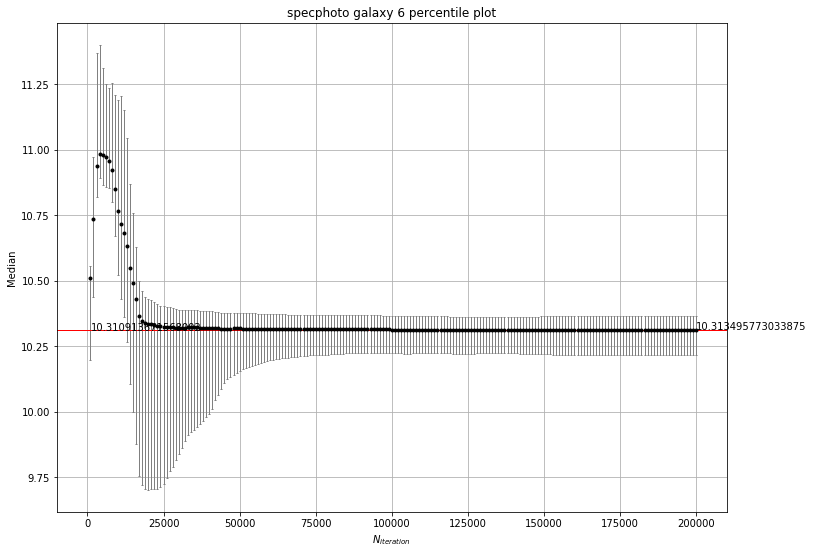

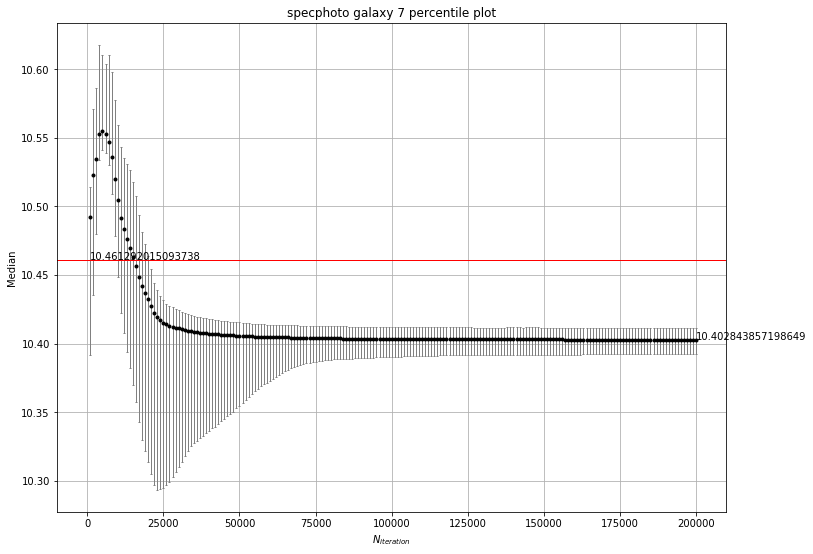

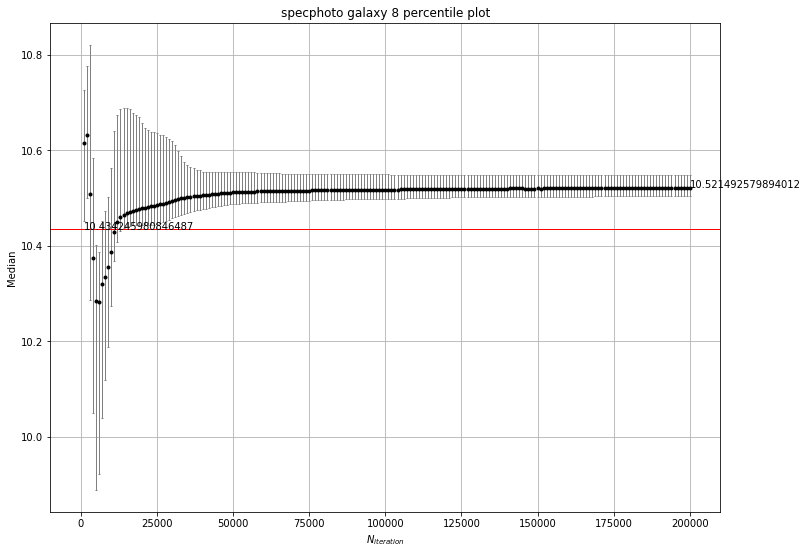

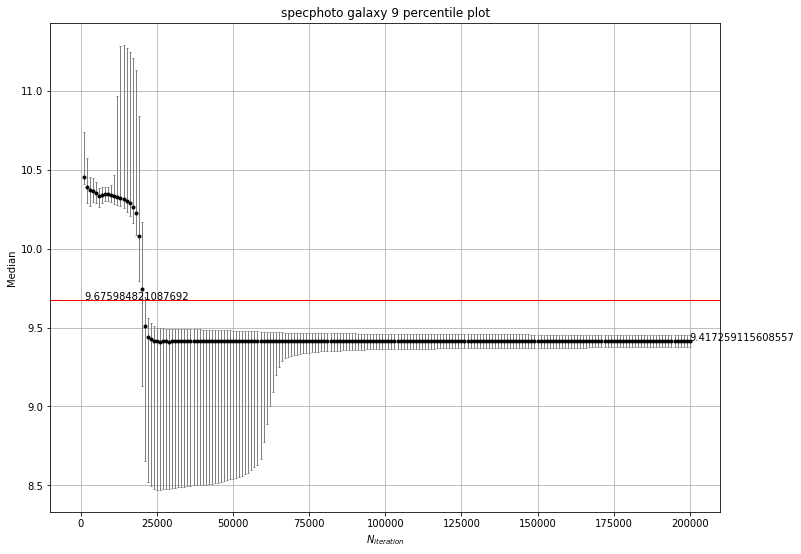

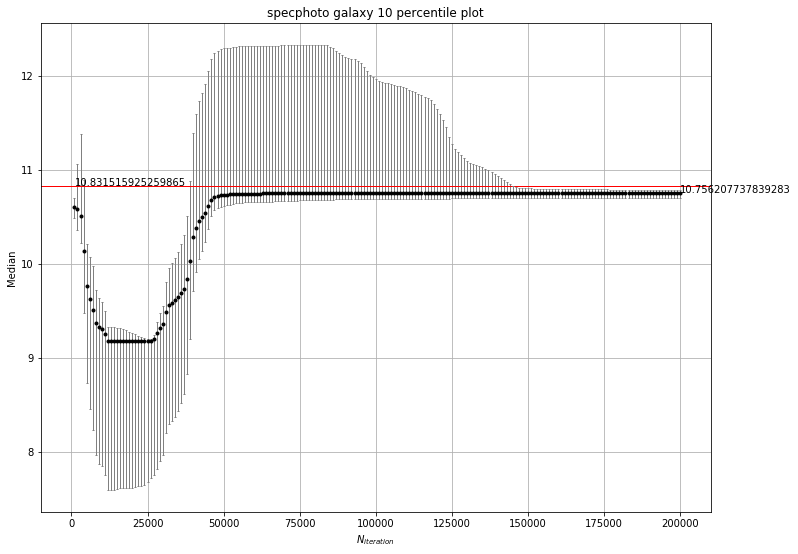

In [7]:
Adptv.avg_perc_plot('specphoto')

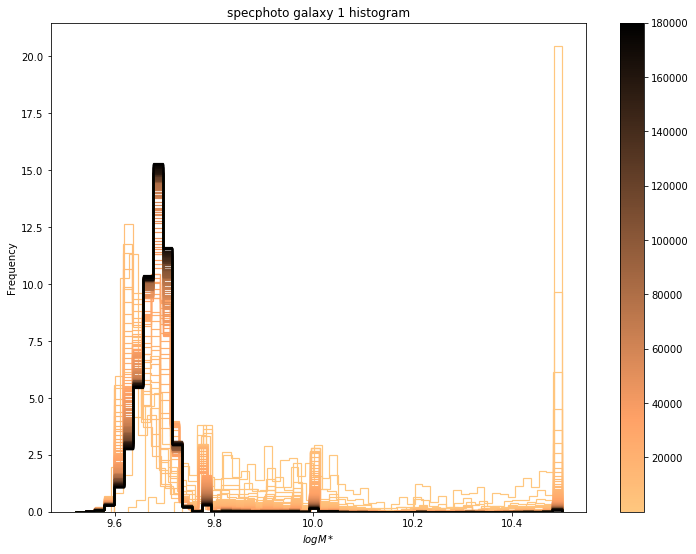

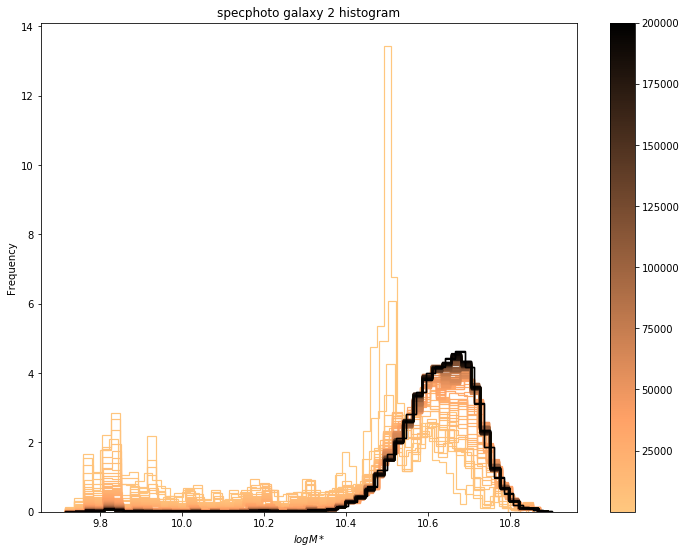

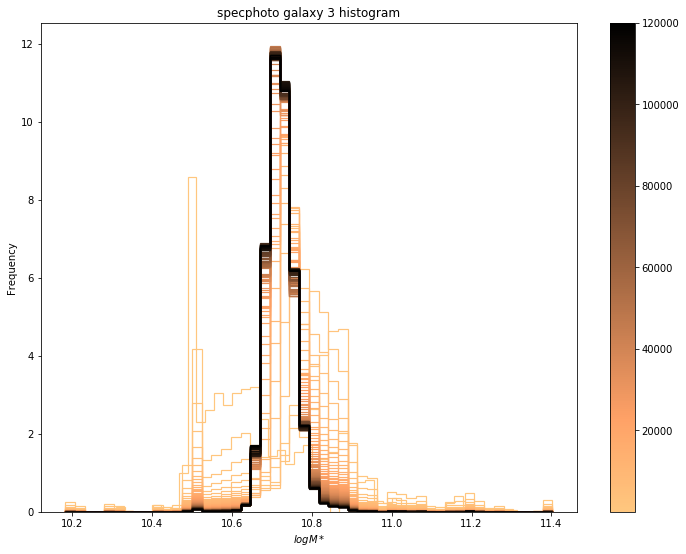

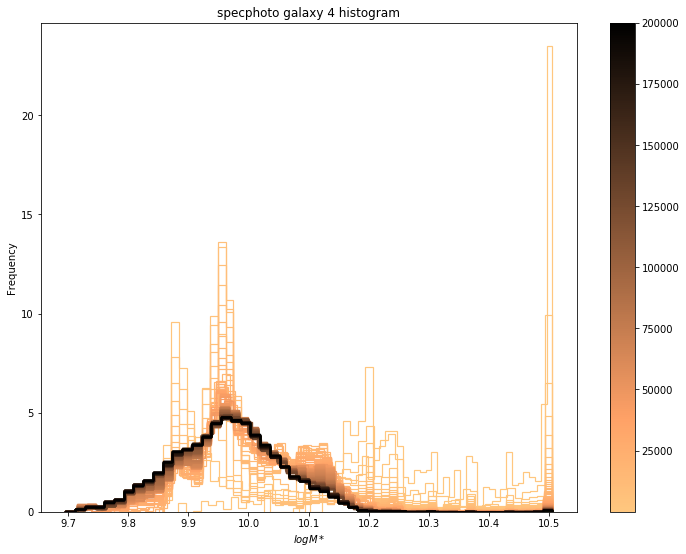

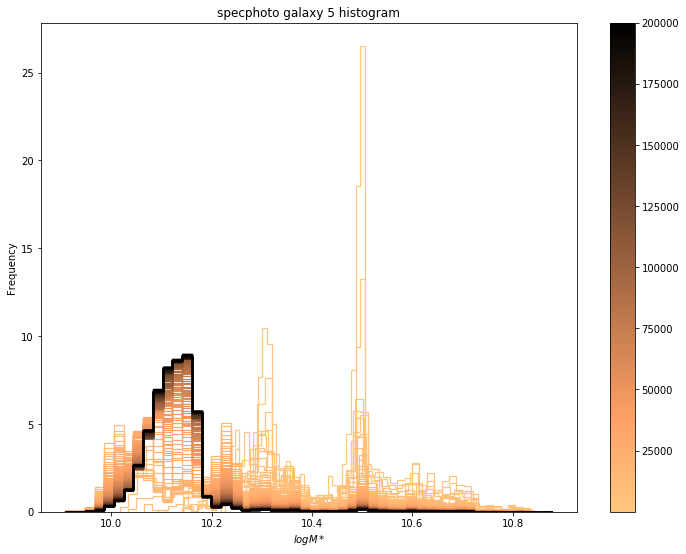

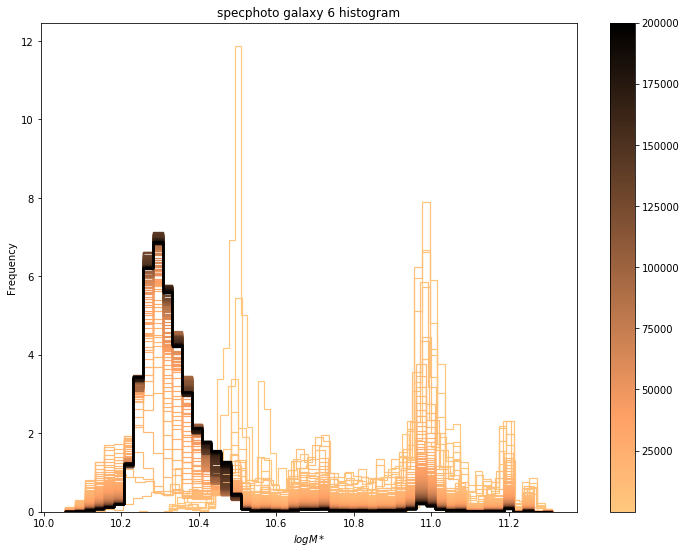

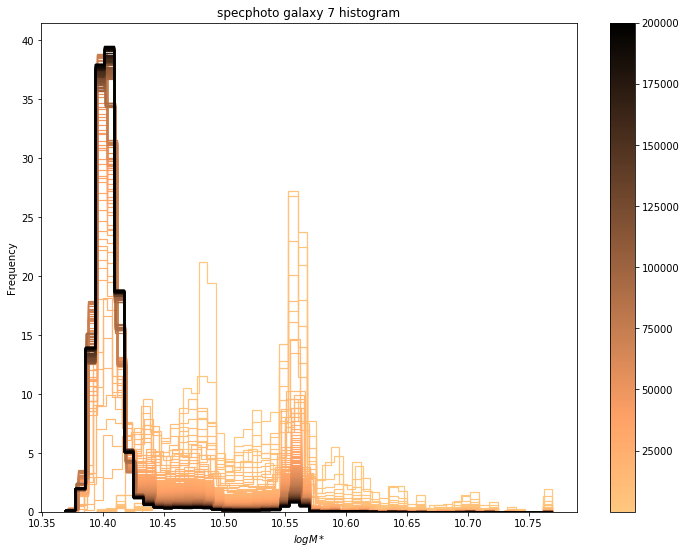

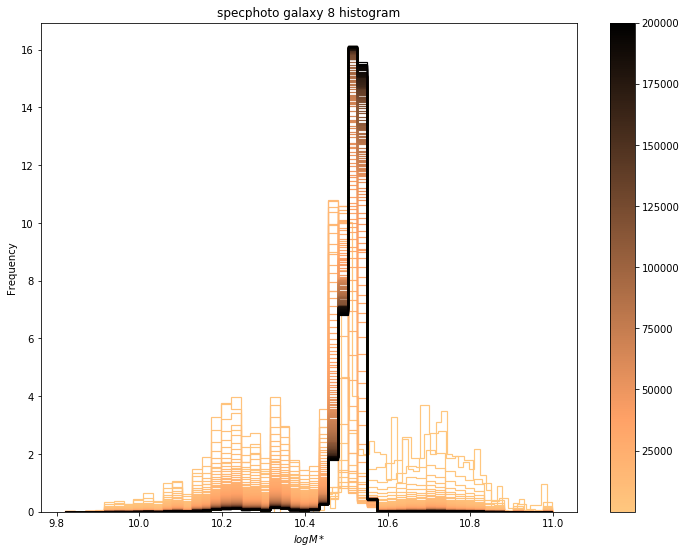

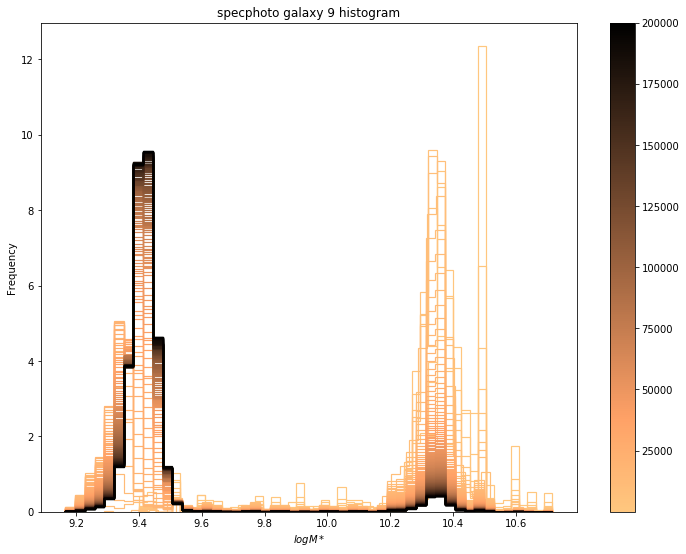

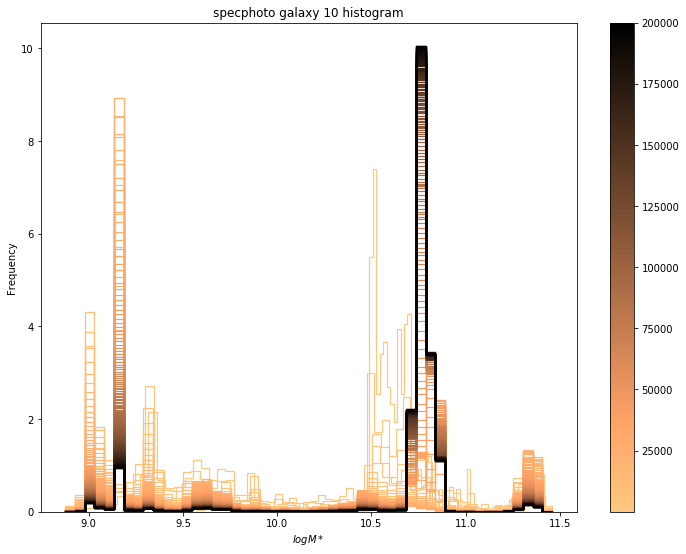

In [8]:
Adptv.hist_plot('specphoto')

In [308]:
Adptv3 = convergence_plotter(20,10000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/walker_scattering')
Adptv3.opener()

['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/walker_scattering/lgal.specphoto.noise_none.vanilla.0.hdf5', '/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/walker_scattering/lgal.specphoto.noise_none.vanilla.1.hdf5', '/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/walker_scattering/lgal.specphoto.noise_none.vanilla.2.hdf5', '/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/walker_scattering/lgal.specphoto.noise_none.vanilla.3.hdf5']


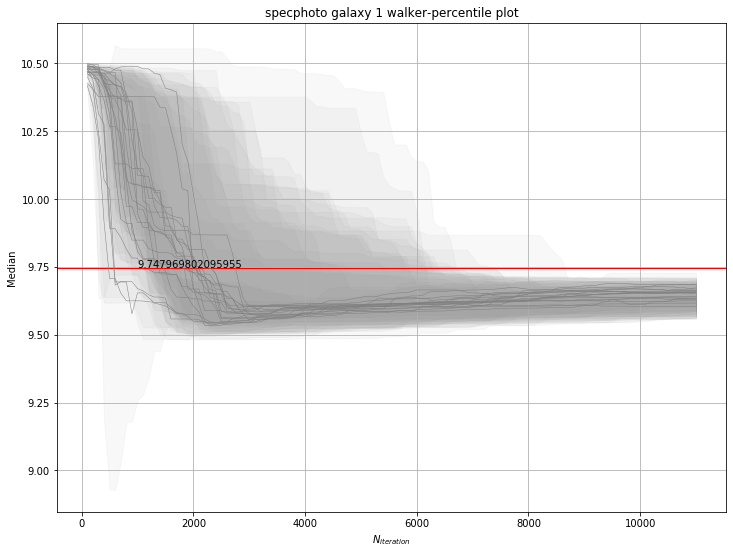

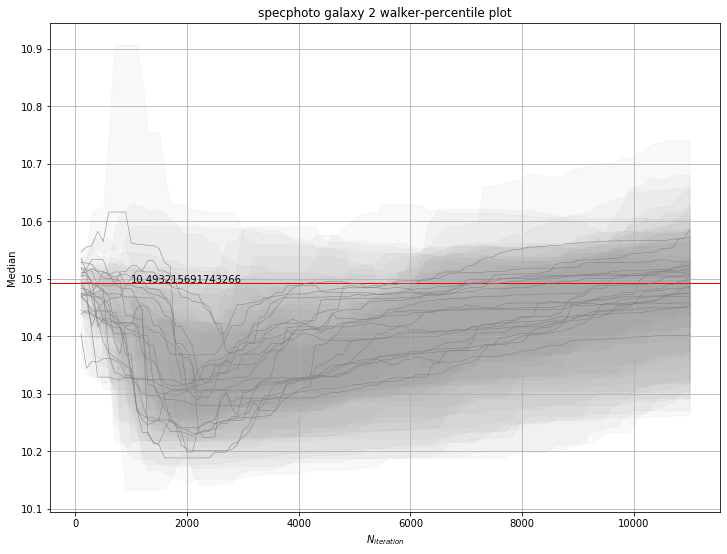

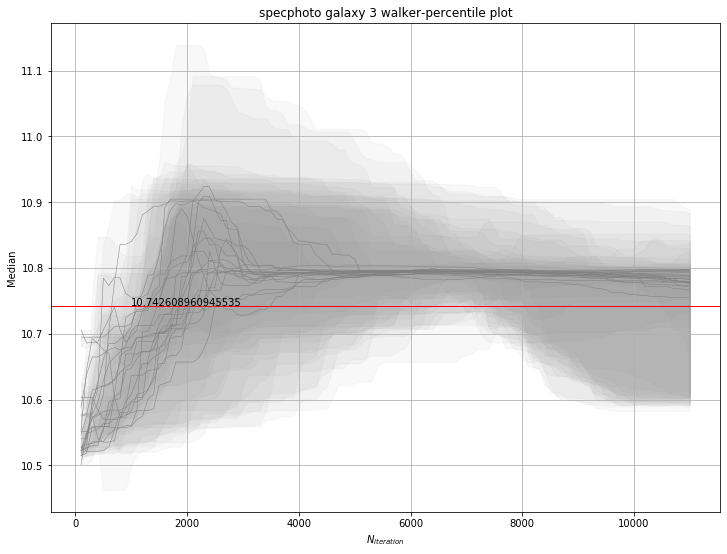

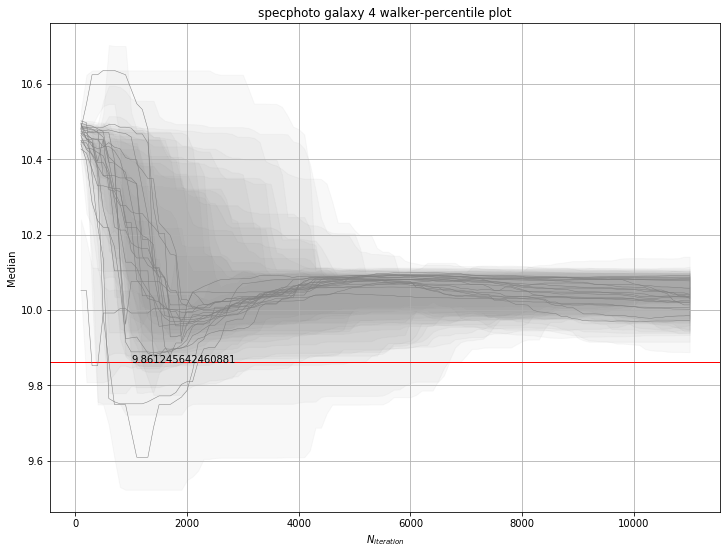

In [309]:
Adptv3.walker_perc_plot('specphoto',step = 100)

In [15]:
x2 = convergence_plotter(20,11000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/scattering_magnitude_test/2x')
x2.opener()
x5 = convergence_plotter(20,11000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/scattering_magnitude_test/5x')
x5.opener()
x8 = convergence_plotter(20,11000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/scattering_magnitude_test/8x')
x8.opener()
x10 = convergence_plotter(20,11000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/scattering_magnitude_test/10x')
x10.opener()

['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/scattering_magnitude_test/2x/2x.hdf5']
['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/scattering_magnitude_test/5x/5x.hdf5']
['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/scattering_magnitude_test/8x/8x.hdf5']
['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/scattering_magnitude_test/10x/10x.hdf5']


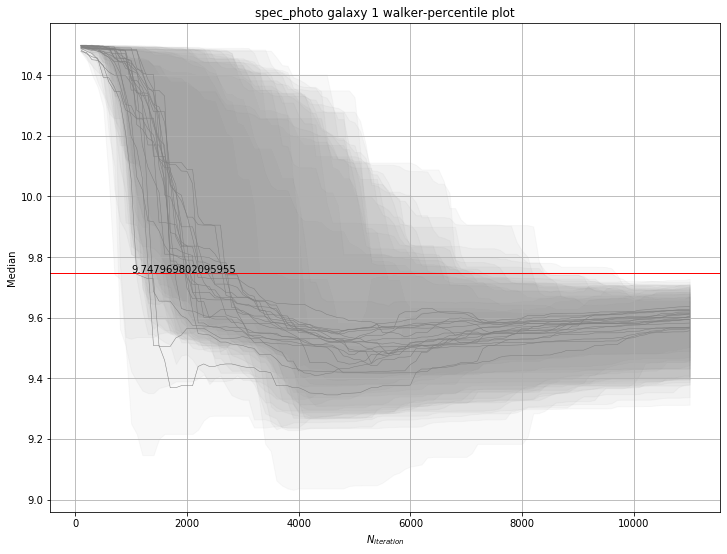

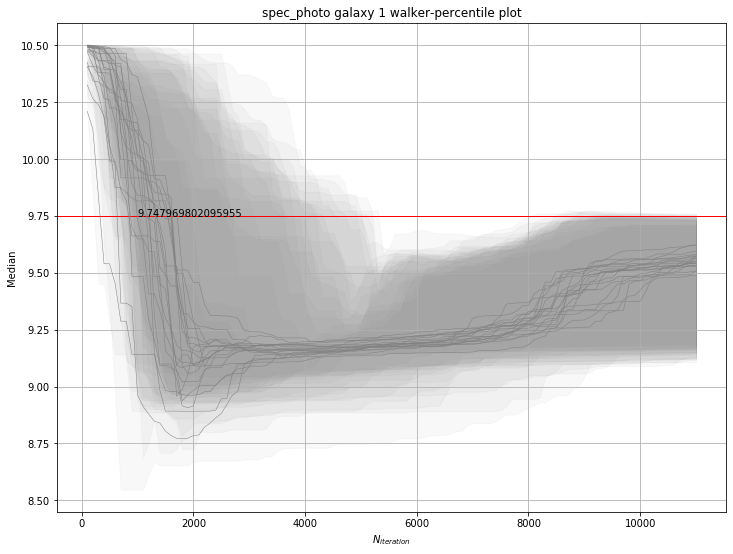

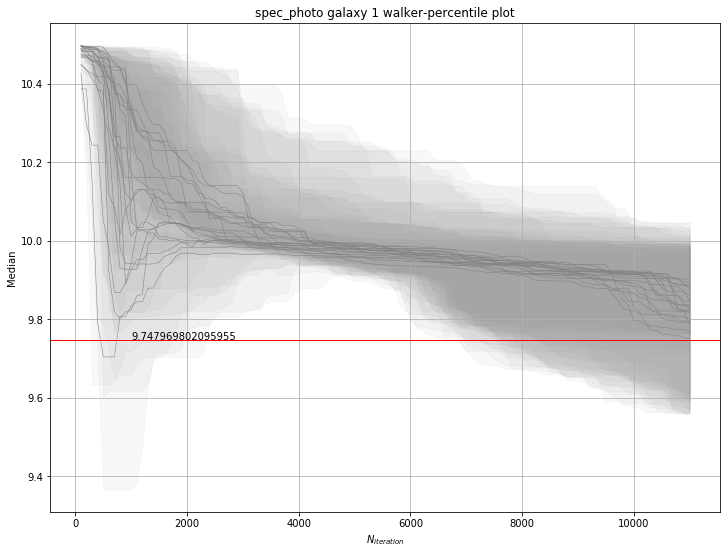

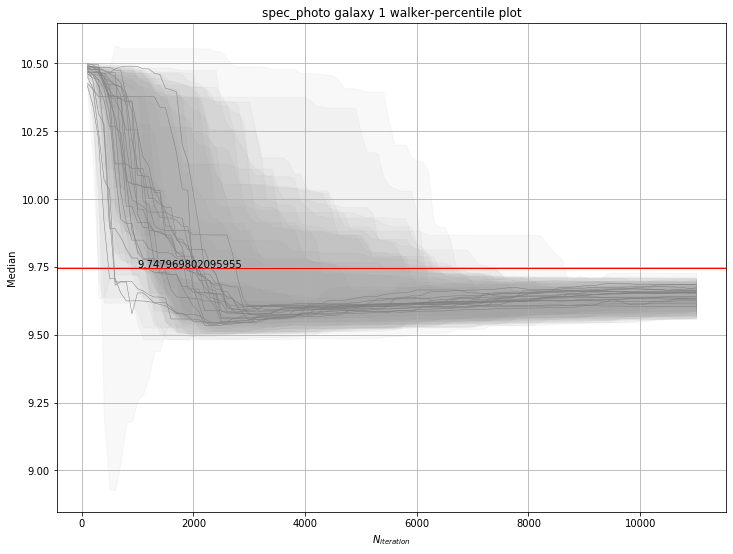

In [16]:
x2.walker_perc_plot('spec_photo',step = 100)
x5.walker_perc_plot('spec_photo',step = 100)
x8.walker_perc_plot('spec_photo',step = 100)
x10.walker_perc_plot('spec_photo',step= 100)